In [1]:
import numpy as np
from scipy import linalg
import pandas as pd

In [2]:
# Read it in
path = "../data/surveys.xlsx"
survey_32W = pd.read_excel('Survey_32N and 32W consolidated.xlsx', sheet_name="Survey_32W", converters={'T3':str})
survey_32N = pd.read_excel('Survey_32N and 32W consolidated.xlsx', sheet_name="Survey_32N")

# Drop unnecessary columns
survey_32W.drop(columns=['Unnamed: 0', 'subject_id', 'image_name', 'image_name_2'], inplace=True)
survey_32N.drop(columns=['Unnamed: 0', 'subject_id', 'image_name', 'image_name_2'], inplace=True)

# Drop rows missing response
survey_32W = survey_32W[
    (survey_32W['T3'] != ' ') &
    (survey_32W['T3'] != 'none') &
    (survey_32W['T3'].notnull()) &
    (survey_32W['T3'] != 'No Comments ') &
    (survey_32W['T3'] != 0) &
    (survey_32W['T3'] != 'None') &
    (survey_32W['T3'] != '[NO ANSWER]')]

# Select responses
res_together = survey_32W['T3'][survey_32W['T1'] == "['They should be together in the same outfits']"].tolist()
res_separate = survey_32W['T3'][survey_32W['T1'] == "['They should be in separate outfits']"].tolist()

res_N = survey_32N['T5'].tolist()
long_together = survey_32W['T4'][survey_32W['T1'] == "['They should be together in the same outfits']"].tolist()
long_separate = survey_32W['T3'][survey_32W['T1'] == "['They should be in separate outfits']"].tolist()

# Importing Embedding tool

In [3]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('bert-base-nli-stsb-mean-tokens')

In [4]:
no_float = [i for i in res_N if type(i) != float]
print(len(no_float))
no_unclear = [i for i in no_float if '[unclear]' not in i]
print(len(no_unclear))

3461
2435


In [5]:
responses = pd.DataFrame({'Responses': no_unclear})

In [6]:
all_sentences = []
response_numbers = []
idx = 1
for i in responses['Responses']:
    temp = i.split('.')
    for k in temp:
        response_numbers.append(idx)
    for j in temp:
        all_sentences.append(j)
    idx += 1

In [7]:
len(all_sentences)

10510

In [8]:
len(response_numbers)

10510

In [9]:
split_responses = pd.DataFrame({'Individual_sentences': all_sentences, 'Response #': response_numbers, 'Pure_index':
                               range(0, len(all_sentences))})

In [33]:
split_responses

,Individual_sentences,Response #,Pure_index
0,Negroes have been told many times they're figh...,1,0
1,But a colored soldier is more discriminated a...,1,1
2,Its evident to those who care to see it that ...,1,2
3,Since the Emancipation Proclamation Negroes h...,1,3
4,"Each right, each privilege was fought for",1,4
...,...,...,...
10505,This his your war and I am just fighting in it,2434,10505
10506,,2434,10506
10507,I think personally this questionnaire is a goo...,2435,10507
10508,It bring out the opinion of the soldiers and ...,2435,10508


# Including DEIM implementation

In [11]:
def DEIM(V):
    #Modified Row Selection
    E = np.identity(len(V))
    Pcol = []
    p1 = np.argmax(abs(V[:,0]))
    Pcol.append(p1)
    
    for j in range(1, np.shape(V)[1]):
        Ei = np.array([E[i] for i in Pcol])
        Vi = np.transpose(np.array([V[:, i] for i in range(0, j)]))
        inv = linalg.inv(Ei @ Vi)
        P_i = Vi @ inv @ Ei
        ri = V[:, j] - P_i @ V[:, j]
        Pcol.append(np.argmax(abs(ri)))
        
    return Pcol

In [12]:
list_of_sentences = split_responses['Individual_sentences'].to_list()

In [13]:
embeddings = model.encode(list_of_sentences)

In [14]:
U, S, Vt = linalg.svd(embeddings)

In [15]:
np.shape(embeddings)

(10510, 768)

In [16]:
my_matrix = np.array([list(np.array(i)) for i in embeddings])

In [17]:

U, S, Vt = linalg.svd(my_matrix, full_matrices = False)

In [18]:
def DEIM(M): # row/column selection
        p = []
        p.append(np.argmax(np.abs(M[:,0]))) # row index of the largest value in the first column of M
        for i in range(1,768):
            res = M[:,i] - np.dot(M[:,:i],np.dot(np.linalg.inv(M[:,:i][p]), M[:,i][p]))
            p.append(np.argmax(np.abs(res)))
        return p

In [20]:
rankings = DEIM(U)

In [40]:
response_idx = []
count = 0
for i in rankings:
    temp = split_responses.loc[i][1]
    if temp not in response_idx:
        response_idx.append(temp)

In [44]:
ordered_responses = [no_unclear[i] for i in response_idx]

In [46]:
final = pd.DataFrame({'Ordered Responses': ordered_responses})

In [48]:
final.to_excel('ordered_responses_sentence_embedding.xlsx')

In [52]:
sep = [i.split(' ') for i in ordered_responses]

In [54]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Response Length against DEIM index')

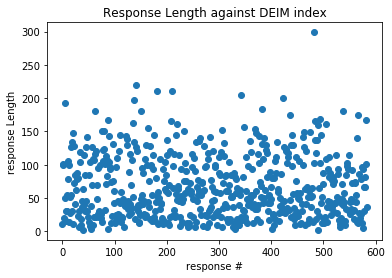

In [60]:
plt.plot([len(i) for i in sep], 'o')
plt.xlabel('response #')
plt.ylabel('response Length')
plt.title('Response Length against DEIM index')

In [64]:
lengths = [len(i) for i in sep]
tempsum = 0
av = []
for i in range(0, len(lengths)):
    if i % 5 == 0:
        av.append(tempsum / 5)
        tempsum = 0
    tempsum += lengths[i]

Text(0.5, 1.0, 'Response Length against DEIM index')

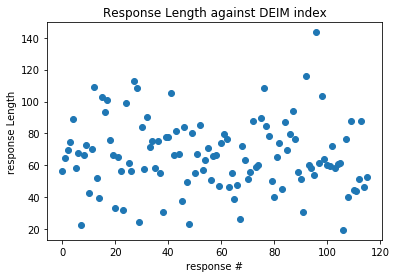

In [70]:
plt.plot(av[1:], 'o')
plt.xlabel('response #')
plt.ylabel('response Length')
plt.title('Response Length against DEIM index')

117